In [73]:
#1.
while True:
    name = input('Enter first name :')
    if name.find(' ') != -1:
        print('Entered name not valid, Enter first name only')       
    else:
        break

if name[-1] in ['a','e','i', 'A', 'E', 'I']:
    print('female') #since i know most of the female names in English or Latin ends with a,e or i whereas male names typically end with consonants.
else:
    print('male')

Enter first name :Raj
male


In [74]:
import requests, json

def getGenders(names):
    url = ""
    cnt = 0
    if not isinstance(names,list):
        names = [names,]
    
    for name in names:
        if url == "":
            url = "name[0]=" + name
        else:
            cnt += 1
            url = url + "&name[" + str(cnt) + "]=" + name
        

    req = requests.get("https://api.genderize.io?" + url) # using genderize.io API 
    results = json.loads(req.text)
    
    retrn = []
    for result in results:
        if result["gender"] is not None:
            retrn.append((result["gender"], result["probability"], result["count"]))
        else:
            retrn.append((u'None',u'0.0',0.0))
    return retrn

if __name__ == '__main__':
    print(getGenders(["Brian","Arnab","Jessica","Zaeem","NotAName"]))

[('male', 1, 4600), ('male', 1, 32), ('female', 1, 6696), ('male', 1, 2), ('None', '0.0', 0.0)]


In [34]:
#2.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [35]:
data=pd.read_csv('/home/jeet/Downloads/gender-classifier.csv',encoding='latin-1')

In [36]:
data.head(5)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,...,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,...,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,...,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,...,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,...,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,...,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN


In [37]:
# Drop unnecessary columns/features
data.drop (columns = ['_unit_id',
                      '_last_judgment_at',
                      'user_timezone',
                      'tweet_coord',
                      'tweet_count',
                      'tweet_created', 
                      'tweet_id',
                      'tweet_location',
                      'profileimage',
                      'created'], inplace = True)

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 16 columns):
_golden                  20050 non-null bool
_unit_state              20050 non-null object
_trusted_judgments       20050 non-null int64
gender                   19953 non-null object
gender:confidence        20024 non-null float64
profile_yn               20050 non-null object
profile_yn:confidence    20050 non-null float64
description              16306 non-null object
fav_number               20050 non-null int64
gender_gold              50 non-null object
link_color               20050 non-null object
name                     20050 non-null object
profile_yn_gold          50 non-null object
retweet_count            20050 non-null int64
sidebar_color            20050 non-null object
text                     20050 non-null object
dtypes: bool(1), float64(2), int64(3), object(10)
memory usage: 2.3+ MB


In [39]:
data.head(3)

,_golden,_unit_state,_trusted_judgments,gender,gender:confidence,profile_yn,profile_yn:confidence,description,fav_number,gender_gold,link_color,name,profile_yn_gold,retweet_count,sidebar_color,text
0,False,finalized,3,male,1.0000,yes,1.0,i sing my own rhythm.,0,NaN,08C2C2,sheezy0,NaN,0,FFFFFF,Robbie E Responds To Critics After Win Against...
1,False,finalized,3,male,1.0000,yes,1.0,I'm the author of novels filled with family dr...,68,NaN,0084B4,DavdBurnett,NaN,0,C0DEED,ÛÏIt felt like they were my friends and I was...
2,False,finalized,3,male,0.6625,yes,1.0,louis whining and squealing and all,7696,NaN,ABB8C2,lwtprettylaugh,NaN,1,C0DEED,i absolutely adore when louis starts the songs...


In [40]:
data['gender'].value_counts()
# We can see that there are 1117 unknown genders, so get rid of them

female     6700
male       6194
brand      5942
unknown    1117
Name: gender, dtype: int64

In [41]:
drop_items_idx = data[data['gender'] == 'unknown'].index

data.drop (index = drop_items_idx, inplace = True)

data['gender'].value_counts()

female    6700
male      6194
brand     5942
Name: gender, dtype: int64

In [42]:
print ('profile_yn information:\n',data['profile_yn'].value_counts())

data[data['profile_yn'] == 'no']['gender']

profile_yn information:
 yes    18836
no        97
Name: profile_yn, dtype: int64


109      NaN
137      NaN
496      NaN
582      NaN
679      NaN
749      NaN
1179     NaN
1664     NaN
1698     NaN
1963     NaN
2118     NaN
2245     NaN
2272     NaN
2377     NaN
2537     NaN
2596     NaN
2717     NaN
2751     NaN
2765     NaN
2886     NaN
2980     NaN
3190     NaN
3195     NaN
3219     NaN
3337     NaN
3381     NaN
3553     NaN
3791     NaN
3942     NaN
4008     NaN
        ... 
12103    NaN
12889    NaN
13007    NaN
14045    NaN
15018    NaN
15243    NaN
15270    NaN
15428    NaN
15450    NaN
15740    NaN
15921    NaN
16208    NaN
16365    NaN
16640    NaN
16886    NaN
16991    NaN
17114    NaN
17163    NaN
18001    NaN
18048    NaN
18063    NaN
18070    NaN
18122    NaN
18136    NaN
18303    NaN
18524    NaN
18700    NaN
18840    NaN
19773    NaN
19842    NaN
Name: gender, Length: 97, dtype: object

It is shown that all of 97 instances with profile_yn == no are all NaN in gender.

Therefore, i get rid of these 97 instances. Also, i get rid of profile_yn, profile_yn:confidence and profile_yn_gold as they are not useful anymore.

In [43]:
drop_items_idx = data[data['profile_yn'] == 'no'].index

data.drop (index = drop_items_idx, inplace = True)

print (data['profile_yn'].value_counts())

data.drop (columns = ['profile_yn','profile_yn:confidence','profile_yn_gold'], inplace = True)

yes    18836
Name: profile_yn, dtype: int64


In [44]:
# Double check the data 
print (data['gender'].value_counts())

print ('---------------------------')
data.info()

female    6700
male      6194
brand     5942
Name: gender, dtype: int64
---------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18836 entries, 0 to 20049
Data columns (total 13 columns):
_golden               18836 non-null bool
_unit_state           18836 non-null object
_trusted_judgments    18836 non-null int64
gender                18836 non-null object
gender:confidence     18836 non-null float64
description           15522 non-null object
fav_number            18836 non-null int64
gender_gold           50 non-null object
link_color            18836 non-null object
name                  18836 non-null object
retweet_count         18836 non-null int64
sidebar_color         18836 non-null object
text                  18836 non-null object
dtypes: bool(1), float64(1), int64(3), object(8)
memory usage: 1.9+ MB


In [45]:
# I decide to keep only 100% confidence of labeling Gender and get rid of those < 100% confidence.
print ('Full data items: ', data.shape)
print ('Data with label-confidence < 100%: ', data[data['gender:confidence'] < 1].shape)
#Here, i can observe that approximately 26.7% (5032/18836) of labeled instances were lower 100% of confidence.
# Then, i get rid of those instances and the feature gender:confidence as it is now useful anymore.

Full data items:  (18836, 13)
Data with label-confidence < 100%:  (5032, 13)


In [46]:
drop_items_idx = data[data['gender:confidence'] < 1].index

data.drop (index = drop_items_idx, inplace = True)

print (data['gender:confidence'].value_counts())

data.drop (columns = ['gender:confidence'], inplace = True)

1.0    13804
Name: gender:confidence, dtype: int64


In [47]:
#Getting rid of remaining useful features 
data.drop (columns = ['_golden','_unit_state','_trusted_judgments','gender_gold'], inplace = True)

# Double check the data 
print (data['gender'].value_counts())

print ('---------------------------')
data.info()

female    5367
male      4653
brand     3784
Name: gender, dtype: int64
---------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13804 entries, 0 to 20049
Data columns (total 8 columns):
gender           13804 non-null object
description      11773 non-null object
fav_number       13804 non-null int64
link_color       13804 non-null object
name             13804 non-null object
retweet_count    13804 non-null int64
sidebar_color    13804 non-null object
text             13804 non-null object
dtypes: int64(2), object(6)
memory usage: 970.6+ KB


In [48]:
#Removing stop-words in Tweets¶
from collections import Counter

twit_vocab = Counter()
for twit in data['text']:
    for word in twit.split(' '):
        twit_vocab[word] += 1

twit_vocab.most_common(20)

[('the', 8370),
 ('and', 7964),
 ('to', 4196),
 ('I', 3229),
 ('a', 3064),
 ('of', 2741),
 ('in', 2270),
 ('you', 2173),
 ('for', 2157),
 ('The', 2018),
 ('is', 1878),
 ('on', 1621),
 ('my', 1362),
 ('it', 1205),
 ('', 1184),
 ('with', 1156),
 ('Weather', 1074),
 ('that', 1032),
 ('from', 1022),
 ('me', 1001)]

In [49]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jeet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [50]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

twit_vocab_reduced = Counter()
for w, c in twit_vocab.items():
    if not w in stop:
        twit_vocab_reduced[w]=c

twit_vocab_reduced.most_common(20)

[('I', 3229),
 ('The', 2018),
 ('', 1184),
 ('Weather', 1074),
 ('-', 767),
 ("I'm", 651),
 ('like', 628),
 ('Get', 627),
 ('get', 570),
 ('Updates', 538),
 ('Channel.', 537),
 ('And', 487),
 ('one', 416),
 ('&amp;', 348),
 ('new', 343),
 ('love', 340),
 ('people', 315),
 ('time', 301),
 ('go', 290),
 ('know', 288)]

I still see a very uneven distribution. 
We're also taking into consideration punctuation signs ('-', ',', etc) and other html tags like &amp.
We can definitely remove them for the sentiment analysis, but we will try to keep the emoticons, since those do have a sentiment load.

In [51]:
import re

def preprocessor(text):
    """ Return a cleaned version of text
    """
    # Remove HTML markup
    text = re.sub('<[^>]*>', '', text)
    # Save emoticons for later appending
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    # Remove any non-word character and append the emoticons,
    # removing the nose character for standarization. Convert to lower case
    text = (re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-', ''))
    
    return text

print(preprocessor('This!!@ tweet :) is <b>nice</b>'))


this tweet is nice :)


In [52]:
from nltk.stem import PorterStemmer

porter = PorterStemmer()

def tokenizer(text):
    return text.split()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

print(tokenizer('Hi there, I am loving this, like with a lot of love'))
print(tokenizer_porter('Hi there, I am loving this, like with a lot of love'))

['Hi', 'there,', 'I', 'am', 'loving', 'this,', 'like', 'with', 'a', 'lot', 'of', 'love']
['Hi', 'there,', 'I', 'am', 'love', 'this,', 'like', 'with', 'a', 'lot', 'of', 'love']


# Data Visualization

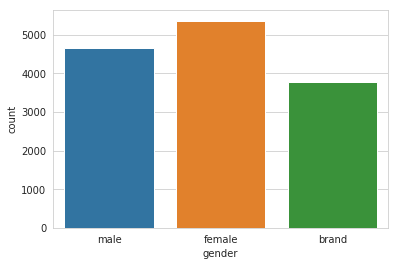

In [53]:
#Create a countplot to visualize the amount of each label
sns.countplot(data['gender'],label="Gender")

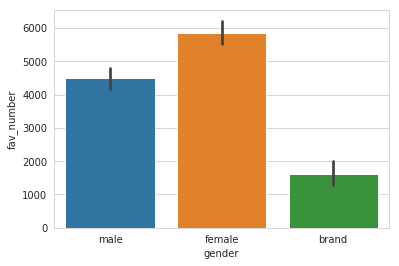

In [54]:
#Bar plot to visualize the amount of favorites and retweets
sns.barplot (x = 'gender', y = 'fav_number',data = data)

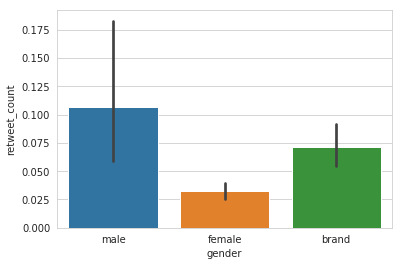

In [55]:
sns.barplot (x = 'gender', y = 'retweet_count',data = data)

# Visualize Colors attribute

['C0DEED' 'FFFFFF' '000000' 'EEEEEE' '181A1E' 'A8C7F7' '5ED4DC']


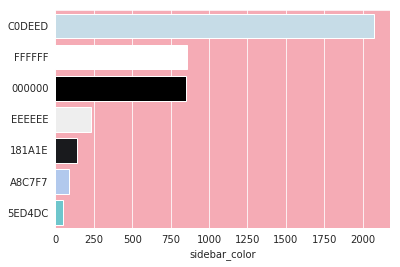

In [56]:
male_top_sidebar_color = data[data['gender'] == 'male']['sidebar_color'].value_counts().head(7)
male_top_sidebar_color_idx = male_top_sidebar_color.index
male_top_color = male_top_sidebar_color_idx.values

male_top_color[2] = '000000'
print (male_top_color)
l = lambda x: '#'+x

sns.set_style("darkgrid", {"axes.facecolor": "#F5ABB5"})
sns.barplot (x = male_top_sidebar_color, y = male_top_color, palette=list(map(l, male_top_color)))

['C0DEED' 'FFFFFF' '000000' 'EEEEEE' '65B0DA' '5ED4DC' 'CC3366']


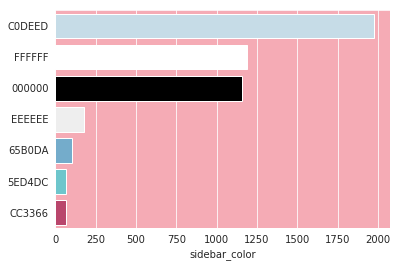

In [57]:
female_top_sidebar_color = data[data['gender'] == 'female']['sidebar_color'].value_counts().head(7)
female_top_sidebar_color_idx = female_top_sidebar_color.index
female_top_color = female_top_sidebar_color_idx.values

female_top_color[2] = '000000'
print (female_top_color)

l = lambda x: '#'+x

sns.set_style("darkgrid", {"axes.facecolor": "#F5ABB5"})
sns.barplot (x = female_top_sidebar_color, y = female_top_color, palette=list(map(l, female_top_color)))

In [ ]:
#For sidebar color, the top 3 colors of both male and female are the same (this seems to be these colors are default theme color of Twitter). 
# It is shown that the number of 2nd and 3rd color of female is larger but this can be explained by the fact that the number of female users are more than male.
#So sidebar_color may not give any useful information.

['0084B4' '009999' '3B94D9' '2FC2EF' 'DD2E44' '000000' 'ABB8C2']


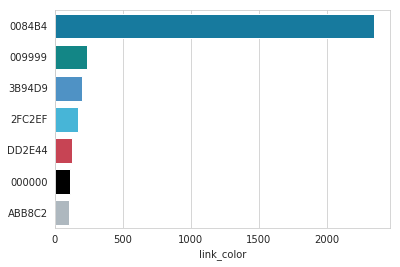

In [58]:
male_top_link_color = data[data['gender'] == 'male']['link_color'].value_counts().head(7)
male_top_link_color_idx = male_top_link_color.index
male_top_color = male_top_link_color_idx.values
male_top_color[1] = '009999'
male_top_color[5] = '000000'
print(male_top_color)

l = lambda x: '#'+x

sns.set_style("whitegrid", {"axes.facecolor": "white"})
sns.barplot (x = male_top_link_color, y = male_top_link_color_idx, palette=list(map(l, male_top_color)))

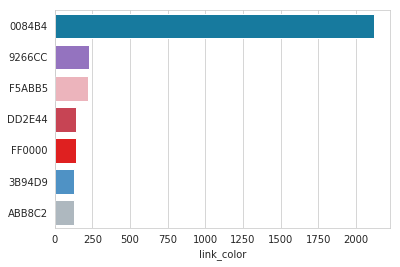

In [59]:
female_top_link_color = data[data['gender'] == 'female']['link_color'].value_counts().head(7)
female_top_link_color_idx = female_top_link_color.index
female_top_color = female_top_link_color_idx.values

l = lambda x: '#'+x

sns.set_style("whitegrid", {"axes.facecolor": "white"})
sns.barplot (x = female_top_link_color, y = female_top_link_color_idx, palette=list(map(l, female_top_color)))

# Training classification models with Tweet-text only(TF-IDF)

In [60]:
# Firstly, convert categorical labels into numerical ones
# Function for encoding categories
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y = encoder.fit_transform(data['gender'])


# split the dataset in train and test
X = data['text']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
#In the code line above, stratify will create a train set with the same class balance than the original set

X_train.head()

19087    @rvpisarapist my players literally give 110% a...
11212    Backers of the atrium lobby considered joining...
14799    I was supposed to receive my @SpiritHalloween ...
6846     Depression comes when you least expect it, lik...
1226     Grimes Throws a Fun, Bloody Party in "Flesh Wi...
Name: text, dtype: object

In [61]:
#Logistics Regression Model
from sklearn.linear_model import LogisticRegression

tfidf = TfidfVectorizer(lowercase=False,
                        tokenizer=tokenizer_porter,
                        preprocessor=preprocessor)
clf = Pipeline([('vect', tfidf),
                ('clf', LogisticRegression(multi_class='ovr', random_state=0))])

clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print('Accuracy:',accuracy_score(y_test,predictions))
print('Confusion matrix:\n',confusion_matrix(y_test,predictions))
print('Classification report:\n',classification_report(y_test,predictions))

/home/jeet/miniconda3/envs/pi3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Accuracy: 0.5999517141477547
Confusion matrix:
 [[ 872  116  148]
 [ 215 1051  344]
 [ 256  578  562]]
Classification report:
              precision    recall  f1-score   support

          0       0.65      0.77      0.70      1136
          1       0.60      0.65      0.63      1610
          2       0.53      0.40      0.46      1396

avg / total       0.59      0.60      0.59      4142



/home/jeet/miniconda3/envs/pi3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/home/jeet/miniconda3/envs/pi3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/home/jeet/miniconda3/envs/pi3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np

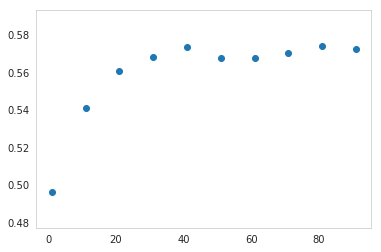

In [62]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
# Plot the correlation between n_estimators and accuracy

# X_train_sample = X_train.head(5000) # this is series
# y_train_sample = y_train[:5000] # this is array

# print (X_train_sample.shape)
# print (y_train_sample.shape)

n = range (1,100,10) #step 10

results = []
for i in n:
    clf = Pipeline([('vect', tfidf),
                ('clf', RandomForestClassifier(n_estimators = i, random_state=0))])
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    results.append(accuracy_score(y_test, predictions))
plt.grid()
plt.scatter(n, results)

#With approximately 40 trees, Random Forest classifier starts reaching the highest performance.

In [63]:
tfidf = TfidfVectorizer(lowercase=False,
                        tokenizer=tokenizer_porter,
                        preprocessor=preprocessor)
clf = Pipeline([('vect', tfidf),
                ('clf', RandomForestClassifier(n_estimators = 40, random_state=0))])

clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print('Accuracy:',accuracy_score(y_test,predictions))
print('Confusion matrix:\n',confusion_matrix(y_test,predictions))
print('Classification report:\n',classification_report(y_test,predictions))

/home/jeet/miniconda3/envs/pi3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/home/jeet/miniconda3/envs/pi3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Accuracy: 0.570738773539353
Confusion matrix:
 [[ 700  259  177]
 [ 122 1195  293]
 [ 155  772  469]]
Classification report:
              precision    recall  f1-score   support

          0       0.72      0.62      0.66      1136
          1       0.54      0.74      0.62      1610
          2       0.50      0.34      0.40      1396

avg / total       0.57      0.57      0.56      4142



In [64]:
# SVM model
from sklearn.svm import SVC

tfidf = TfidfVectorizer(lowercase=False,
                        tokenizer=tokenizer_porter,
                        preprocessor=preprocessor)
clf = Pipeline([('vect', tfidf),
                ('clf', SVC(kernel = 'linear'))])
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print('Accuracy:',accuracy_score(y_test,predictions))
print('Confusion matrix:\n',confusion_matrix(y_test,predictions))
print('Classification report:\n',classification_report(y_test,predictions))


/home/jeet/miniconda3/envs/pi3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Accuracy: 0.598020280057943
Confusion matrix:
 [[ 858  117  161]
 [ 219 1010  381]
 [ 243  544  609]]
Classification report:
              precision    recall  f1-score   support

          0       0.65      0.76      0.70      1136
          1       0.60      0.63      0.62      1610
          2       0.53      0.44      0.48      1396

avg / total       0.59      0.60      0.59      4142



# Adding content of Description into Text

In [65]:
data.head(3)

,gender,description,fav_number,link_color,name,retweet_count,sidebar_color,text
0,male,i sing my own rhythm.,0,08C2C2,sheezy0,0,FFFFFF,Robbie E Responds To Critics After Win Against...
1,male,I'm the author of novels filled with family dr...,68,0084B4,DavdBurnett,0,C0DEED,ÛÏIt felt like they were my friends and I was...
3,male,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202,0084B4,douggarland,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...


Concatenating 'description' to 'text'

In [66]:
#Fill NaN with empty string
data.fillna("", inplace = True)

# Concatenate text with description, add white space between. 
# By using Series helper functions Series.str()
data['text_description'] = data['text'].str.cat(data['description'], sep=' ')

data['text_description'].isnull().value_counts() # Check if any null values, True if there is at least one.

False    13804
Name: text_description, dtype: int64

Re-create training dataset

In [67]:
# split the dataset in train and test
X = data['text_description']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
#In the code line above, stratify will create a train set with the same class balance than the original set

X_train.head()
X_train.isnull().values.any() # Check if any null values, True if there is at least one.

False

In [68]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

tfidf = TfidfVectorizer(lowercase=False,
                        tokenizer=tokenizer_porter,
                        preprocessor=preprocessor)
clf = Pipeline([('vect', tfidf),
                ('clf', LogisticRegression(multi_class='ovr', random_state=0))])

clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print('Accuracy:',accuracy_score(y_test,predictions))
print('Confusion matrix:\n',confusion_matrix(y_test,predictions))
print('Classification report:\n',classification_report(y_test,predictions))

/home/jeet/miniconda3/envs/pi3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Accuracy: 0.6817962337035248
Confusion matrix:
 [[ 959   80   97]
 [ 137 1192  281]
 [ 191  532  673]]
Classification report:
              precision    recall  f1-score   support

          0       0.75      0.84      0.79      1136
          1       0.66      0.74      0.70      1610
          2       0.64      0.48      0.55      1396

avg / total       0.68      0.68      0.67      4142



/home/jeet/miniconda3/envs/pi3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/home/jeet/miniconda3/envs/pi3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/home/jeet/miniconda3/envs/pi3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np

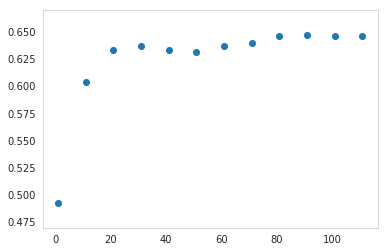

In [69]:
# Using SVM 
# Plot the correlation between n_estimators and accuracy

# X_train_sample = X_train.head(5000) # this is series
# y_train_sample = y_train[:5000] # this is array

# print (X_train_sample.shape)
# print (y_train_sample.shape)

n = range (1,120,10) #step 10

results = []
for i in n:
    clf = Pipeline([('vect', tfidf),
                ('clf', RandomForestClassifier(n_estimators = i, random_state=0))])
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    results.append(accuracy_score(y_test, predictions))
plt.grid()    
plt.scatter(n, results)

#With approximately 80 trees, Random Forest classifier starts reaching the highest performance.

In [70]:
from sklearn.ensemble import RandomForestClassifier

tfidf = TfidfVectorizer(lowercase=False,
                        tokenizer=tokenizer_porter,
                        preprocessor=preprocessor)
clf = Pipeline([('vect', tfidf),
                ('clf', RandomForestClassifier(n_estimators = 80, random_state=0))])

clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print('Accuracy:',accuracy_score(y_test,predictions))
print('Confusion matrix:\n',confusion_matrix(y_test,predictions))
print('Classification report:\n',classification_report(y_test,predictions))

/home/jeet/miniconda3/envs/pi3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/home/jeet/miniconda3/envs/pi3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Accuracy: 0.6438918396909705
Confusion matrix:
 [[ 883  147  106]
 [ 108 1339  163]
 [ 143  808  445]]
Classification report:
              precision    recall  f1-score   support

          0       0.78      0.78      0.78      1136
          1       0.58      0.83      0.69      1610
          2       0.62      0.32      0.42      1396

avg / total       0.65      0.64      0.62      4142



In [71]:
#SVM model
from sklearn.svm import SVC

tfidf = TfidfVectorizer(lowercase=False,
                        tokenizer=tokenizer_porter,
                        preprocessor=preprocessor)
clf = Pipeline([('vect', tfidf),
                ('clf', SVC(kernel = 'linear'))])
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print('Accuracy:',accuracy_score(y_test,predictions))
print('Confusion matrix:\n',confusion_matrix(y_test,predictions))
print('Classification report:\n',classification_report(y_test,predictions))


/home/jeet/miniconda3/envs/pi3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Accuracy: 0.6868662481892805
Confusion matrix:
 [[ 952   82  102]
 [ 117 1169  324]
 [ 178  494  724]]
Classification report:
              precision    recall  f1-score   support

          0       0.76      0.84      0.80      1136
          1       0.67      0.73      0.70      1610
          2       0.63      0.52      0.57      1396

avg / total       0.68      0.69      0.68      4142



# Ensemble Method

In [72]:
from sklearn.ensemble import VotingClassifier
clf1 = LogisticRegression(multi_class='ovr', random_state=0)
clf2 = RandomForestClassifier(n_estimators = 80, random_state=0)
clf3 = SVC(kernel = 'linear',probability = True, random_state=0)

ensemble_clf = VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('svm', clf3)], voting='soft')

clf = Pipeline([('vect', tfidf),
                ('clf', ensemble_clf)])

clf.fit(X_train, y_train)

# ensemble_clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print('Accuracy:',accuracy_score(y_test,predictions))
print('Confusion matrix:\n',confusion_matrix(y_test,predictions))
print('Classification report:\n',classification_report(y_test,predictions))

/home/jeet/miniconda3/envs/pi3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
/home/jeet/miniconda3/envs/pi3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Accuracy: 0.6900048285852245
Confusion matrix:
 [[ 960   84   92]
 [ 120 1241  249]
 [ 172  567  657]]
Classification report:
              precision    recall  f1-score   support

          0       0.77      0.85      0.80      1136
          1       0.66      0.77      0.71      1610
          2       0.66      0.47      0.55      1396

avg / total       0.69      0.69      0.68      4142



/home/jeet/miniconda3/envs/pi3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
